In [34]:
import networkx as nx
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.rcParams['figure.dpi'] = 200

# Methyl-5-CpG basecall comparisons
---
This is a note file devoted to the creation of code to compare Methyl-5C calls from several different sequencing platforms to identify any biases or deficiencies. Comparisons between Bisulfite sequencing, HiFi basemod and ONT basemod calls will be made with an effort to identify precision and recall among each dataset. 

Let's first start by creating new methods and helper classes to read the data for the comparison.

In [35]:
from collections import defaultdict
import gzip
import math

def func(s):
    tokens = s.split('_')
    for i in range(2):
        token = s[i]
        try:
            v = int(token)
            return ('.'.join(tokens[0:i]), v)
        except ValueError:
            pass
    return (s, 0)

class sparseArrayHelper:
    
    def __init__(self):
        self.data = defaultdict(dict)
        self.ucscToIdx = dict()
        self.sampleToIdx = dict()
        self.sparse = None
        self.srtArray = []
        
    def getCol(self, second):
        if len(self.srtArray) == 0:
            self.srtArray = sorted(list(self.data.keys()), key=func)
        vec = []
        for i, c in enumerate(self.srtArray):
            self.ucscToIdx[c] = i
            if math.isnan(self.data[c].get(second, 0.0)):
                print(f'Error NaN! {c} {second}')
            vec.append(self.data[c].get(second, 0.0))
                
        return vec
        
    def toSparse(self):
        if len(self.srtArray) == 0:
            self.srtArray = sorted(list(self.data.keys()), key=func)
        numSamples = len(self.sampleToIdx.keys())
        
        
        for i, c in enumerate(srtArray):
            self.ucscToIdx[c] = i
            for j, k in enumerate(list(self.sampleToIdx.keys())):
                self.sparse[i, j] = self.data[c].get(k, 0.0)
                
        self.data = dict()
        
    def loadPacB(self, file, limit = None, ftype="PacB"):
        num = len(self.sampleToIdx.keys())
        self.sampleToIdx[ftype] = num
        with open(file, 'r') as input:
            for l in input: 
                s = l.rstrip().split()
                if limit != None:
                    if s[0] != limit:
                        continue
                self.data[f'{s[0]}_{s[2]}'][ftype] = float(s[8])
                
    def loadBisulf(self, file, limit = None, ftype="BiSulf"):
        num = len(self.sampleToIdx.keys())
        self.sampleToIdx[ftype] = num
        
        with gzip.open(file, mode='rt') as input:
            for l in input:
                s = l.rstrip().split()
                s[0] = s[0].replace('_', '-')
                if limit != None:
                    if s[0] != limit:
                        continue             
                
                self.data[f'{s[0]}_{s[2]}'][ftype] = float(s[5]) * 100.0
                
    def loadONT(self, file, limit=None, ftype="ONT"):
        num = len(self.sampleToIdx.keys())
        self.sampleToIdx[ftype] = num
        
        with gzip.open(file, mode='rt') as input:
            for l in input:
                s = l.rstrip().split()
                if limit != None:
                    if s[0] != limit:
                        continue
                if s[10] == "nan":
                    continue
                self.data[f'{s[0]}_{s[2]}'][ftype] = float(s[10]) 
                
    def toDataFrame(self, cols):
        return pd.DataFrame({k : self.getCol(k) for k in cols}, columns=cols)

---
#### Friesian test

OK, let's try an initial test with the Bisulfite data from the Churro x Friesian cross, aligned only to the Friesian.

In [36]:
worker = sparseArrayHelper()

# Load Bisulfite data
worker.loadBisulf("C:/SharedFolders/sequencing_projects/methyl5c_comparison/SAM113662CF_Sheep_Friesian_CGonly_MethCalls.gz", limit="haplotype1-0000001")
print("Loaded Bisulfite")

# Load PacBio data
worker.loadPacB("C:/SharedFolders/sequencing_projects/methyl5c_comparison/friesian.pbcpg.model.combined.denovo.mincov4.bed", limit="haplotype1-0000001")
print("Loaded PacB")

#worker.toSparse()



Loaded Bisulfite
Loaded PacB


Bisulf sum: 193453925.0, count 2924913
PacB sum: 117041446.39999998, count 2924913


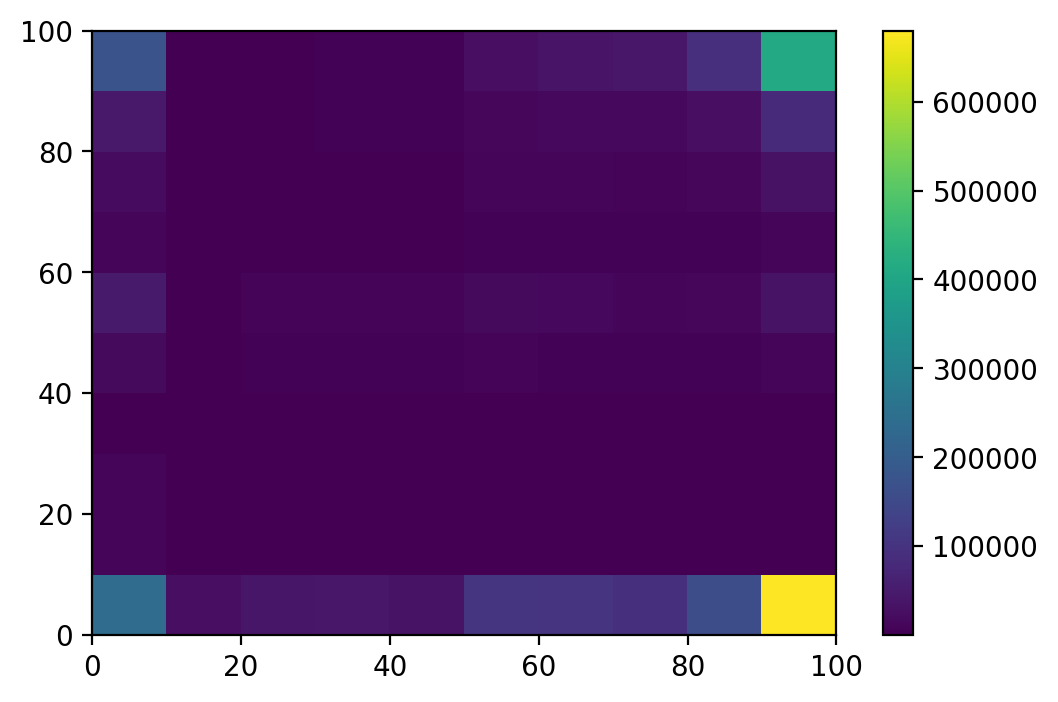

In [37]:
# Create a density heatmap to show the correlation of points

from scipy.stats.kde import gaussian_kde
x = list(worker.getCol("BiSulf")) # Bisulf
y = list(worker.getCol("PacB")) # PacB

print("Bisulf sum: {}, count {}".format(np.sum(x), len(x)))
print("PacB sum: {}, count {}".format(np.sum(y), len(y)))

Z, xedges, yedges = np.histogram2d(x, y)


plt.pcolormesh(xedges, yedges, Z.T)
plt.colorbar()
plt.show()

Loaded ONT
[75.0, 88.0, 67.0, 64.0, 100.0, 40.0, 0.0, 0.0, 100.0, 100.0]
[75.86, 66.67, 78.38, 75.0, 33.33, 13.79, 23.33, 37.5, 55.56, 82.35]
Bisulf sum: 193453925.0, count 2924913
ONT sum: 205777490.03000018, count 2924913


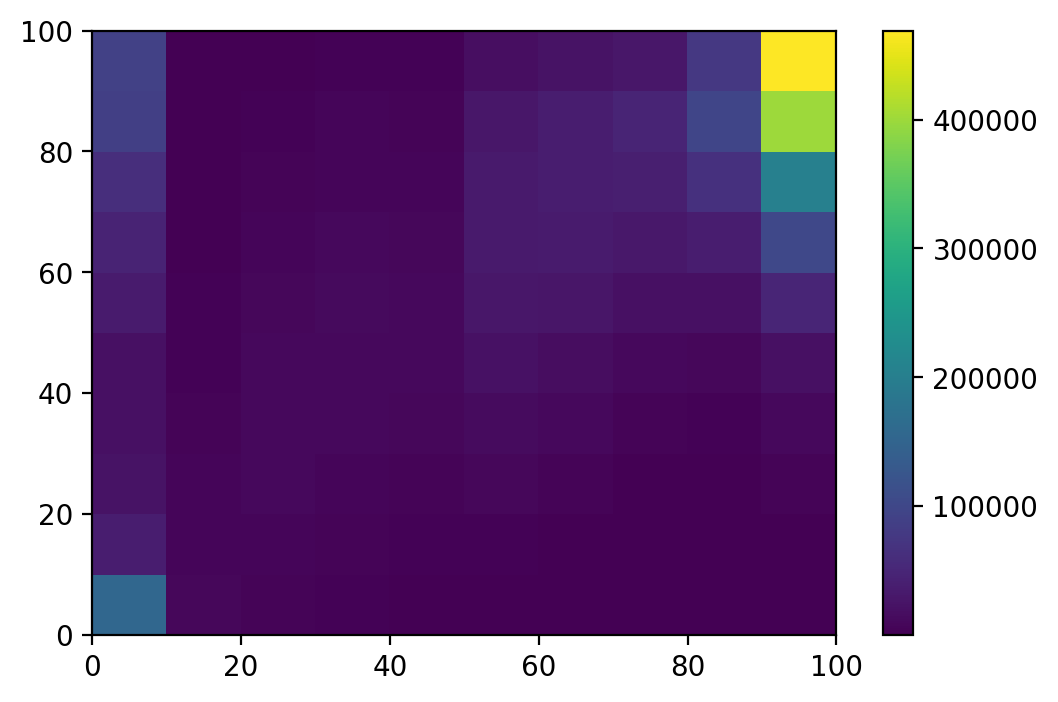

In [38]:
# Load ONT data
worker.loadONT("C:/SharedFolders/sequencing_projects/methyl5c_comparison/Friesian.test.methyl.bed.gz", limit="haplotype1-0000001")
print("Loaded ONT")

from scipy.stats.kde import gaussian_kde
import math
x = list(worker.getCol("BiSulf")) # Bisulf
y = list(worker.getCol("ONT")) # ONT

print(x[:10])
print(y[:10])
print("Bisulf sum: {}, count {}".format(np.sum(x), len(x)))
print("ONT sum: {}, count {}".format(np.sum(y), len(y)))

Z, xedges, yedges = np.histogram2d(x, y)


plt.pcolormesh(xedges, yedges, Z.T)
plt.colorbar()
plt.show()

---
## Correlation

OK, now to generate a correlation matrix from the three data types. The issue is that the dataframe is going to be massive on the entire dataset, so I may need to shrink it at some point.

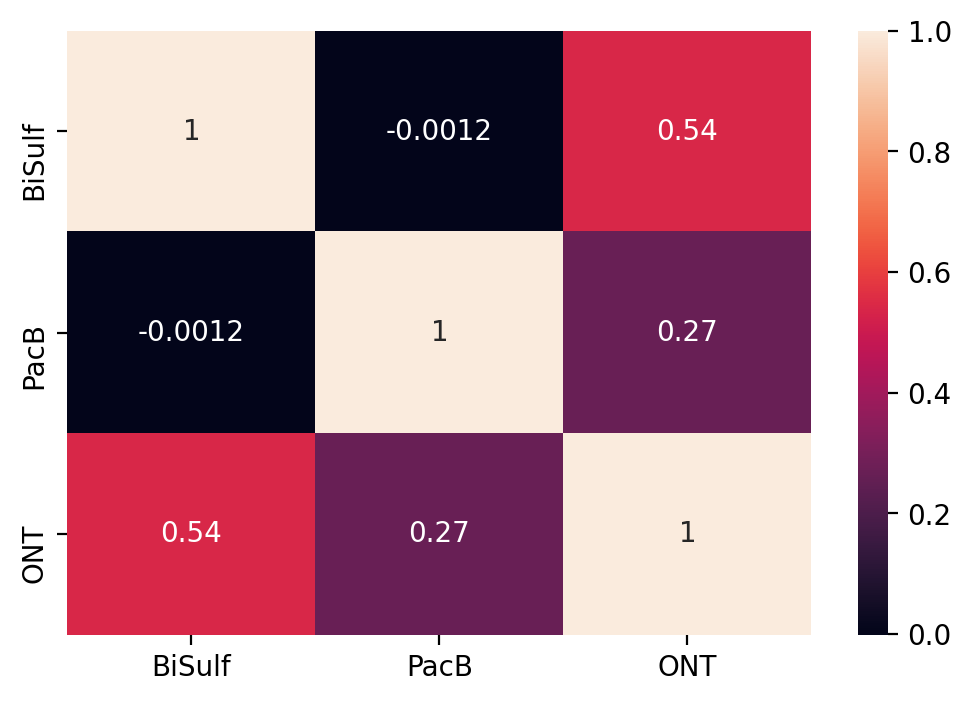

In [41]:
df = worker.toDataFrame(["BiSulf", "PacB", "ONT"])

corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

<AxesSubplot:>

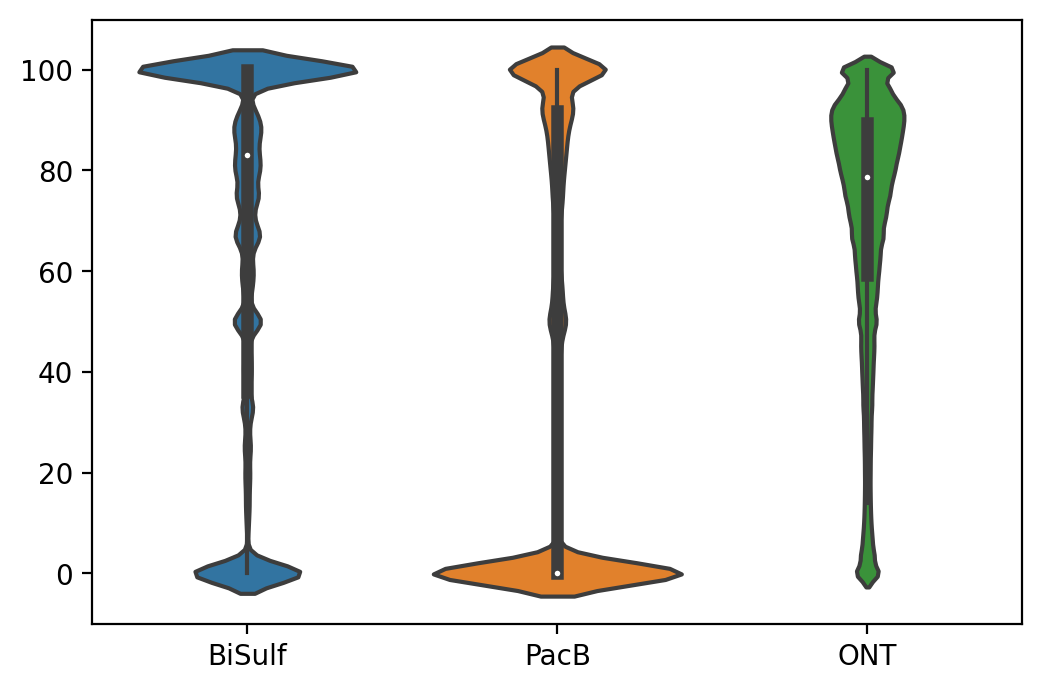

In [42]:
sns.violinplot(data=df)